In [59]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import json
import geopandas
s = json.load(open(os.getenv('PUI2015')+'/plotstyle.json'))
plt.rcParams.update(s)
%matplotlib inline

In [3]:
# have a quick look at the data
path = os.getenv('ADS') + '/project/sh_test.csv'
data = pd.read_csv(path)

In [5]:
catValues = sorted(data['genCategory'].unique())

In [6]:
# create a dictionary of string-int pair.
unique = {catValues[i]:i for i in range(len(catValues))}
# set the numerical value of NaNs to np.nan
unique[np.nan] = np.nan

In [7]:
# transform the dic into a dataframe
cateValues = pd.DataFrame(unique, 
                      index=[1]).T.reset_index().rename(columns={'index':'genCategory',
                                                                 1:'CateValue'})
cateValues

,genCategory,CateValue
0,NaN,NaN
1,Arts & Entertainment,1
2,College & University,2
3,Event,3
4,Food,4
5,Nightlife Spot,5
6,Outdoors & Recreation,6
7,Professional & Other Places,7
8,Residence,8
9,Shop & Service,9


In [8]:
# give pair the genCategory of each row with the corresponding categorical value
data2 = data.merge(cateValues, how='left', on='genCategory')
print data2.shape
data2.head()

(10075, 20)


,genCategory,category,name,lon,lat,checkIns,tips,users,createdAt,tileID,ID,query,time,verified,price,rating,tags,photoCount,description,CateValue
0,Travel & Transport,Hotel,上海天禧嘉福酒店 Skyfortune Boutique Hotel,121.390842,31.183345,217,3,136,2011.09.21,0_00_00_00_10,4e79a8e88877bac8d1cbbfbd,China_Shanghai,2015.11.08 22:54:55,False,-1,-1,NaN,23,NaN,10
1,NaN,Szechuan Restaurant,四川香天下,121.392031,31.183549,9,0,3,2015.08.01,0_00_00_00_10,55bcad8a498e6bfc6d59ee71,China_Shanghai,2015.11.08 22:54:55,False,-1,-1,NaN,1,NaN,NaN
2,Outdoors & Recreation,Golf Course,Hongqiao Golf Driving range,121.386053,31.187153,169,3,82,2012.04.02,0_00_00_00_10,4f79acbfe4b0795c3a0102d6,China_Shanghai,2015.11.08 22:54:56,False,-1,-1,NaN,12,NaN,6
3,Shop & Service,Electronics Store,蘇寧電器吳中路,121.389871,31.182312,10,0,6,2013.01.06,0_00_00_00_10,50e91cfae4b09c384603f0fa,China_Shanghai,2015.11.08 22:54:56,False,-1,-1,NaN,2,NaN,9
4,Food,Japanese Restaurant,龙之介炉端烧,121.387928,31.182557,120,1,51,2010.08.20,0_00_00_00_10,4c6e686c65eda093bd4251d0,China_Shanghai,2015.11.08 22:54:56,False,-1,-1,NaN,8,NaN,4


In [173]:
data3 = data2[(data2['users'] >= 5) &
              (data2['checkIns'] >= 5)] #&
              #(data2['CateValue'] != np.nan)]
data3.shape

(4423, 20)

In [161]:
# print data3.shape
# data3.head()

In [174]:
# calculate the square
latMin = np.min(data3.lat)
latMax = np.max(data3.lat)
lonMin = np.min(data3.lon)
lonMax = np.max(data3.lon)
print (latmin, lonmin), (latmax, lonmax)

(31.171115697638744, 121.38403730828294) (31.31612888083754, 121.54749870300293)


In [175]:
NumRow = 20
NumCol = 20
latStep = (latMax - latMin) / NumRow
lonStep = (lonMax - lonMin) / NumCol

In [176]:
kernels = []
for row in xrange(NumRow):
    for col in xrange(NumCol):
        kernels.append({'cell':((row*latStep+latMin, col*lonStep+lonMin), 
                        ((row+1)*latStep+latMin, (col+1)*lonStep+lonMin)),
                        "atrs": {}})

In [177]:
for i in data3.T:
    lat = data3.T[i].ix['lat']
    lon = data3.T[i].ix['lon']
    
    for kernel in kernels:
        if (lat >= kernel['cell'][0][0]) and (
            lat < kernel['cell'][1][0]) and (
            lon >= kernel['cell'][0][1]) and (
            lon < kernel['cell'][1][1]):
            kernel['atrs'][data3.T[i].ix['genCategory']] = kernel['atrs'].get(data3.T[i].ix['genCategory'],0)+1
            break

In [178]:
kernels[1]

{'atrs': {nan: 3,
  'Arts & Entertainment': 1,
  'Food': 8,
  'Outdoors & Recreation': 2,
  'Professional & Other Places': 10,
  'Shop & Service': 3,
  'Travel & Transport': 3},
 'cell': ((31.17079961051484, 121.39210882567157),
  (31.178072729485887, 121.40033107656988))}

In [179]:
for kernel in kernels:
    kernel['total'] = sum(kernel['atrs'].values())

In [180]:
kList = []
for kernel in kernels:
    d = kernel['atrs']
    d['sw'] = (kernel['cell'][0][1], kernel['cell'][0][0])
    d['se'] = (kernel['cell'][1][1], kernel['cell'][0][0])
    d['ne'] = (kernel['cell'][1][1], kernel['cell'][1][0])
    d['nw'] = (kernel['cell'][0][1], kernel['cell'][1][0])
    
    d['total'] = (kernel['total'])
    kList.append(d)

kDF = pd.DataFrame(kList)

In [181]:
#kDF.index = xrange(100)
kDF.head(3)

,nan,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,ne,nw,se,sw,total
0,5,1,NaN,NaN,14,NaN,NaN,6,NaN,1,4,"(121.392108826, 31.1780727295)","(121.383886575, 31.1780727295)","(121.392108826, 31.1707996105)","(121.383886575, 31.1707996105)",31
1,3,1,NaN,NaN,8,NaN,2,10,NaN,3,3,"(121.400331077, 31.1780727295)","(121.392108826, 31.1780727295)","(121.400331077, 31.1707996105)","(121.392108826, 31.1707996105)",30
2,2,NaN,NaN,NaN,2,NaN,NaN,3,NaN,NaN,1,"(121.408553327, 31.1780727295)","(121.400331077, 31.1780727295)","(121.408553327, 31.1707996105)","(121.400331077, 31.1707996105)",8


In [182]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon

kDF['geometry'] = kDF.apply(lambda x: Polygon([x['sw'], x['se'], x['ne'], x['nw']]), axis=1)
kDF = gp.GeoDataFrame(kDF)

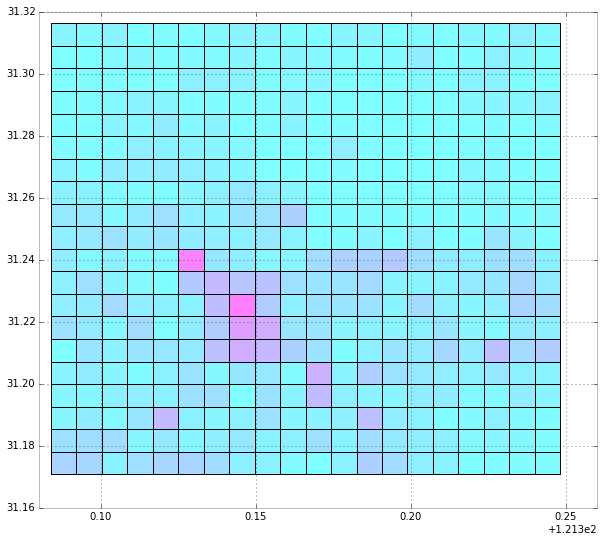

In [183]:
kDF.plot(figsize = (10,10), column='total', colormap='cool')

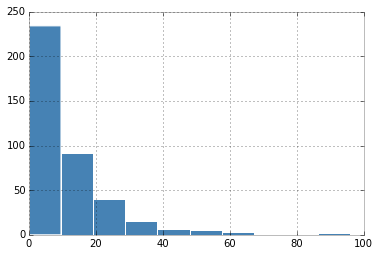

In [184]:
#filter only cells with over 500 complains in total
kDF.total.hist()

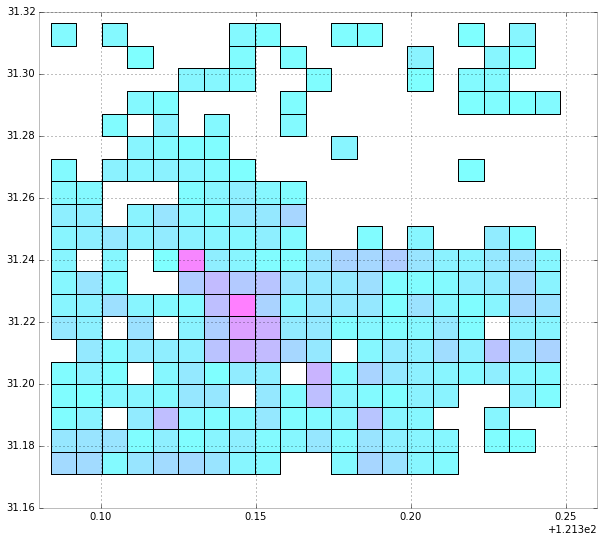

In [186]:
kDF[kDF.total>4].plot(figsize = (10,10), column='total', colormap='cool')
plt.savefig('kernelDensity_Shanghai.png')

In [188]:
for x in kDF.columns.tolist(): print x

nan
Arts & Entertainment
College & University
Event
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport
ne
nw
se
sw
total
geometry


In [189]:
# normalization
kDF.columns
kDF2 = kDF

cols = ['Arts & Entertainment','College & University','Event','Food',
        'Nightlife Spot','Outdoors & Recreation',
        'Professional & Other Places','Residence','Shop & Service',
        'Travel & Transport']

for col in cols:
    kDF2[col] = kDF2[col]/kDF2.total

In [191]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [230]:
s = [0]*10
# select the best k
for i in range(0,10):
    est=KMeans(n_clusters=i+2,n_init=100)
    est.fit(kDF2[cols].fillna(0))
    s[i]=silhouette_score(kDF2[cols].fillna(0), est.labels_)
    print('{0} clusters: {1}'.format(i+2,s[i]))
j=np.argmax(s) # select best k value (max avg silhouette value)    
est=KMeans(n_clusters=j+2,n_init=100)
est.fit(kDF2[cols].fillna(0))
labels=est.labels_
print('Best for {0} clusters: {1}\n'.format(j+2,silhouette_score(kDF2[cols].fillna(0), labels)))

2 clusters: 0.197626613132
3 clusters: 0.239243205229
4 clusters: 0.300705399236
5 clusters: 0.314360485917
6 clusters: 0.300872252436
7 clusters: 0.322146447217
8 clusters: 0.282697156076
9 clusters: 0.317766242583
10 clusters: 0.331322888298
11 clusters: 0.334462441379
Best for 11 clusters: 0.334294115148



In [232]:
est=KMeans(n_clusters=7,n_init=100)
est.fit(kDF2[cols].fillna(0))
labels=est.labels_

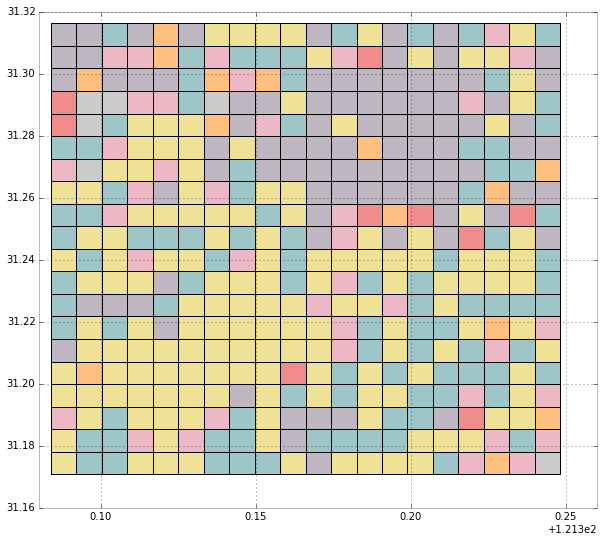

In [235]:
kDF2['labels'] = labels.astype(np.float)
kDF2.plot(figsize = (10,10), column='labels', colormap='Set1')
plt.savefig('kernelDensity_Shanghai.png')

In [234]:
x = kDF2.groupby('labels')

for name, group in x:
    print name
    print group[cols].iloc[0]

0.0
Arts & Entertainment            NaN
College & University            NaN
Event                           NaN
Food                            NaN
Nightlife Spot                  NaN
Outdoors & Recreation           NaN
Professional & Other Places     NaN
Residence                      0.25
Shop & Service                  NaN
Travel & Transport             0.75
Name: 56, dtype: float64
1.0
Arts & Entertainment           0.033333
College & University                NaN
Event                               NaN
Food                           0.266667
Nightlife Spot                      NaN
Outdoors & Recreation          0.066667
Professional & Other Places    0.333333
Residence                           NaN
Shop & Service                 0.100000
Travel & Transport             0.100000
Name: 1, dtype: float64
2.0
Arts & Entertainment          NaN
College & University          NaN
Event                         NaN
Food                          NaN
Nightlife Spot                NaN
Outdoors 

In [ ]:



# s=[0]*20
# for k in range(0,20):
#     est=KMeans(n_clusters=k+2,n_init=100)
#     est.fit(kDF2)
#     s[k]=silhouette_score(Pl, est.labels_)
#     print('{0} clusters: {1}'.format(k+2,s[k]))
# k=np.argmax(s)    
# est=KMeans(n_clusters=k+2,n_init=100)
# est.fit(Pl)
# labels=est.labels_
# plt.figure(figsize=(6,8))
# plt.scatter (x500,y500,s=30,c=labels.astype(np.float),lw=0)
# print('{0} clusters: {1}'.format(k+2,silhouette_score(Pl, labels)))

In [ ]:
#normalize the matrix to deal with the relative complain type frequencies
# X=matrix(X)
# for z in range(0,cellnum):
#     X[z,:]=X[z,:]/sum(X[z,:])
# m=mean(X,0)    
# for i in range(0,compnum):
#     X[:,i]=(X[:,i]-m[0,i])
# X500=X[C>500,:]

In [ ]:
# U, s, Vt = np.linalg.svd(X500)
# V = Vt.T
# ind = np.argsort(s)[::-1]
# U = U[:, ind]
# s = s[ind]
# V = V[:, ind]
# P=X500*np.matrix(V)

In [ ]:
#visualize amount of information covered by PCAs and take 19 leading ones covering 95% of the entire infomation
# sc=cumsum(np.array(s)**2/sum(np.array(s)**2))
# plt.bar(range(1,21),sc[0:20])
# Pl=P[:,0:19]
# print(sc[18])

In [ ]:
# s=[0]*20
# for k in range(0,20):
#     est=KMeans(n_clusters=k+2,n_init=100)
#     est.fit(Pl)
#     s[k]=silhouette_score(Pl, est.labels_)
#     print('{0} clusters: {1}'.format(k+2,s[k]))
# k=np.argmax(s)    
# est=KMeans(n_clusters=k+2,n_init=100)
# est.fit(Pl)
# labels=est.labels_
# plt.figure(figsize=(6,8))
# plt.scatter (x500,y500,s=30,c=labels.astype(np.float),lw=0)
# print('{0} clusters: {1}'.format(k+2,silhouette_score(Pl, labels)))

In [ ]:
# est=KMeans(n_clusters=4,n_init=100)
# est.fit(Pl)
# labels=est.labels_
# plt.figure(figsize=(6,8))
# colors=['blue','green','magenta','red']
# plt.scatter (x500,y500,s=30,color=[colors[l] for l in labels],lw=0)

In [ ]:
# mC1=mean(X500[labels==0,:],0)
# mC2=mean(X500[labels==1,:],0)
# mC3=mean(X500[labels==2,:],0)
# mC4=mean(X500[labels==3,:],0)
# mind=find(m>0.02)
# #print('Compain: average, red, green, blue, magenta')
# clusters=pd.DataFrame({' ComplainType':['All'],'Avg':[1.0],'blue':[1.0],'green':[1.0],'magenta':[1.0],'red':[1.0]})
# for c in mind:
#     #print('{0}: {1}'.format(compinv[c],m[0,c]))
#     clusters.loc[clusters.index.max()+1]=[compinv[c],m[0,c],m[0,c]+mC1[0,c],m[0,c]+mC2[0,c],m[0,c]+mC3[0,c],m[0,c]+mC4[0,c]]
#     #print('{0}: {1:.3g},{2:.3g},{3:.3g},{4:.3g},{5:.3g}'.format(compinv[c],m[0,c],m[0,c]+mC1[0,c],m[0,c]+mC2[0,c],m[0,c]+mC3[0,c],m[0,c]+mC4[0,c]))
# clusters

In [41]:
# z = {0:0,1:0,2:0}

In [42]:
# z[5] = z.get(5,0) + 2
# z

{0: 0, 1: 0, 2: 0, 5: 2}

In [43]:
# z[5] = z.get(5,0) + 2

In [44]:
# z

{0: 0, 1: 0, 2: 0, 5: 4}